Soil moisture drydowns refer to the rate at which soil loses its moisture content over time, typically following a rainfall event. The initial rate of moisture loss is typically rapid, slowing down as the soil reaches a lower moisture content. Thus, this process is often described by an exponential decay model. 

In this exercise we will extract drydown events from a time series of rootzone soil moisture. Basically, a drydown represents the period of moisture loss between precipitation events. Since in this region small rainfall events don't usually contribute to appreciable soil moisture recharge, we will set a tolerance level to ignore small rainfall events.

## Model description

$$ SWC = A \ e^{-t/\tau} + \theta_{res}$$

$SWC$ = Soil water content in $m^{3}/m^{3}$<br>
$A$ = The initial soil water content $m^{3}/m^{3}$. Soil water at time $t=0$<br>
$t$ = Days since rainfall event<br>
$\tau$ = Constant that modulates the rate at which the soil dries<br>
$\theta_{res}$ = Residual soil water content $m^{3}/m^{3}$.


In [1]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from pprint import pprint


In [49]:
# Define model using an anonymous lamda function
model = lambda t,tau,A,S_min: A * np.exp(-t/tau) + S_min
xrange = np.arange(30)


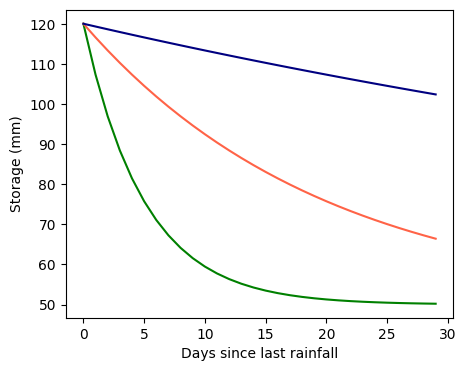

In [50]:
# Create figure with example drydowns
plt.figure(figsize=(5,4))

# Rapid decay. Typical of summer, coarse soils, and actively growing vegetation
plt.plot(xrange, model(xrange,5,70,50), color='green')     

# Drydowns during moderate atmospheric demand (spring and fall)
plt.plot(xrange, model(xrange,20,70,50), color='tomato')

# Drydown during low atmospheric demand (winter)
plt.plot(xrange, model(xrange,100,70,50), color='navy')

plt.xlabel('Days since last rainfall')
plt.ylabel('Storage (mm)')
plt.show()


## Load dataset

In [4]:
# Load data
df = pd.read_csv('../datasets/kings_creek_2022_2023_daily.csv',parse_dates=['datetime'])
df.head()


,datetime,pressure,tmin,tmax,tavg,rmin,rmax,prcp,srad,wspd,wdir,vpd,vwc_5cm,vwc_20cm,vwc_40cm,soiltemp_5cm,soiltemp_20cm,soiltemp_40cm,battv,discharge
0,2022-01-01,96.838,-14.8,-4.4,-9.60,78.475,98.012,0.25,2.098,5.483,0.969,0.028,0.257,0.307,0.359,2.996,5.392,7.425,8714.833,0.0
1,2022-01-02,97.995,-20.4,-7.2,-13.80,50.543,84.936,0.25,9.756,2.216,2.023,0.072,0.256,0.307,0.358,2.562,4.250,6.692,8890.042,0.0
2,2022-01-03,97.844,-9.4,8.8,-0.30,40.622,82.662,0.50,9.681,2.749,5.667,0.262,0.255,0.307,0.358,2.454,3.917,6.208,8924.833,0.0
3,2022-01-04,96.419,0.1,8.6,4.35,48.326,69.402,0.25,8.379,5.806,2.627,0.363,0.289,0.319,0.357,2.496,3.754,5.842,8838.292,0.0
4,2022-01-05,97.462,-11.1,-2.2,-6.65,50.341,76.828,0.00,5.717,4.207,1.251,0.126,0.313,0.337,0.357,1.688,3.429,5.567,8848.083,0.0


In [5]:
# Convert date strings into pandas datetie format
df.insert(1, 'doy', df['datetime'].dt.dayofyear)


In [9]:
# Compute soil water storage in top 50 cm
df['storage'] = df['vwc_5cm']*100 + df['vwc_20cm']*200 + df['vwc_40cm']*200


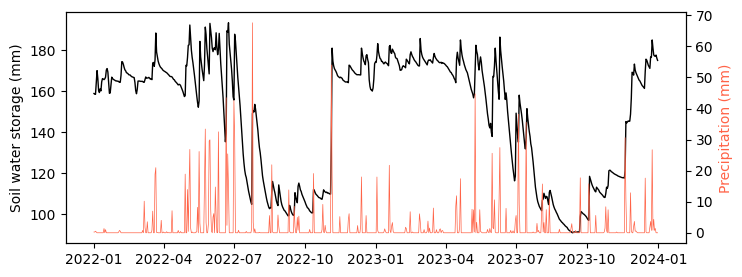

In [18]:
# Plot timeseries of soil moisture and EDDI
plt.figure(figsize=(8,3))

plt.plot(df['datetime'], df['storage'], color='k', linewidth=1.0)
plt.ylabel('Soil water storage (mm)')

plt.twinx()

plt.plot(df['datetime'], df['prcp'], color='tomato', linewidth=0.5)
plt.ylabel('Precipitation (mm)', color='tomato')

plt.show()


In [51]:
# Find residual volumetric water content
storage_min = df['storage'].min()
print(storage_min)

# Define model by forcing minimum storage
model = lambda t,tau,A: A * np.exp(-t/tau) + storage_min

90.80000000000001


In [79]:
# Iterate over soil moisture timeseries to retrieve drydowns
day_counter = 0
drydown_min_length = 7
all_drydowns = []
drydown_event = {'date':[],'storage':[],'doy':[],
                 'days':[],'length':[], 'par':[]}

# We start the loop on the second day
for i in range(1,len(df)):
    delta = df["storage"][i] - df["storage"][i-1]
    
    if delta < 0:
        day_counter += 1
        drydown_event['date'].append(df.loc[i,'datetime'])
        drydown_event['storage'].append(df.loc[i,'storage'])
        drydown_event['doy'].append(df.loc[i,'doy'])
        drydown_event['days'].append(day_counter)
        drydown_event['length'] = day_counter

    else:
        # Avoid saving data for short drydowns
        if day_counter < drydown_min_length:
            
            # Reset variables
            day_counter = 0
            drydown_event = {'date':[],'storage':[],'doy':[],
                             'days':[],'length':[], 'par':[]}
            continue
        else:
            
            # Fit model to drydown event
            par_opt, par_cov = curve_fit(model, 
                                         drydown_event['days'], 
                                         drydown_event['storage'])
            drydown_event['par'] = par_opt
            
            # Append current event
            all_drydowns.append(drydown_event)
            
            # Reset variables
            day_counter = 0
            drydown_event = {'date':[],'storage':[],'doy':[],
                             'days':[],'length':[], 'par':[]}

        
print('There are a total of',len(all_drydowns),'drydowns')   


There are a total of 34 drydowns


In [80]:
# Inspect one drydown event
pprint(all_drydowns[2])


{'date': [Timestamp('2022-04-12 00:00:00'),
          Timestamp('2022-04-13 00:00:00'),
          Timestamp('2022-04-14 00:00:00'),
          Timestamp('2022-04-15 00:00:00'),
          Timestamp('2022-04-16 00:00:00'),
          Timestamp('2022-04-17 00:00:00'),
          Timestamp('2022-04-18 00:00:00'),
          Timestamp('2022-04-19 00:00:00'),
          Timestamp('2022-04-20 00:00:00')],
 'days': [1, 2, 3, 4, 5, 6, 7, 8, 9],
 'doy': [102, 103, 104, 105, 106, 107, 108, 109, 110],
 'length': 9,
 'par': array([156.17218773,  76.60354863]),
 'storage': [167.0,
             166.4,
             165.8,
             165.60000000000002,
             164.9,
             164.5,
             164.1,
             163.6,
             163.1]}


## Overlay soil moisture timeseries and extracted drydowns

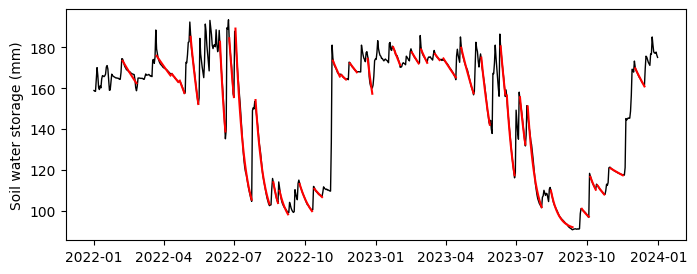

In [81]:
plt.figure(figsize=(8,3))
plt.plot(df['datetime'], df['storage'], color='k', linewidth=1.0)
for event in all_drydowns:
    plt.plot(event['date'], model(np.asarray(event['days']), *event['par']), '-r')

plt.ylabel('Soil water storage (mm)')
plt.show()